<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/wip/mu_lambda_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy --upgrade

In [20]:
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm

In [94]:
data = {}


def generate_random(number):
  values = []
  for i in range(10):
      values.extend([random.uniform(0, 1)])
  return values

#data['Betweeness'] = generate_random(10)
data['x'] = generate_random(10)
data['y'] = generate_random(10)

df = pd.DataFrame(data)
df

,x,y
0,0.428229,0.813616
1,0.410063,0.263973
2,0.484833,0.002100
3,0.306497,0.883439
4,0.286012,0.295527
5,0.363688,0.958583
6,0.424601,0.470911
7,0.225401,0.211288
8,0.324134,0.258537
9,0.836877,0.604633


mu: The number of parents selected each iteration.

lambda: Size of the population.

lambda / mu: Number of children generated from each selected parent.

In [95]:
sample = df.sample(frac=0.3, random_state=0)
sample

,x,y
2,0.484833,0.002100
8,0.324134,0.258537
4,0.286012,0.295527


In [96]:
replace = np.random.rand(sample.shape[0],sample.shape[1])
replace

array([[0.96019856, 0.28849233],
       [0.17295202, 0.33804778],
       [0.02018847, 0.95003816]])

In [97]:
df.loc[sample.index] = replace
df

,x,y
0,0.428229,0.813616
1,0.410063,0.263973
2,0.960199,0.288492
3,0.306497,0.883439
4,0.020188,0.950038
5,0.363688,0.958583
6,0.424601,0.470911
7,0.225401,0.211288
8,0.172952,0.338048
9,0.836877,0.604633


In [98]:
def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [99]:
objective(df)

0.08415312081104412

In [100]:
# check if a point is within the bounds of the search
def in_bounds(point):
	# assuming all dimensions should lie in the same range, e.i. [0,1]
	test = ((point > 0) == (point < 1)).all()
	# Returns True if they are, false otherwise.
	return test

In [109]:
# evolution strategy (mu, lambda) algorithm
def es_comma(initial_record, objective, frac, n_iter, step_size, mu, lam):
  best, best_eval = None, 1e+10
	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = df.copy()
    sample = candidate.sample(frac=frac, random_state=0)
    candidate.loc[sample.index] = np.random.rand(sample.shape[0],sample.shape[1])
    population.append(candidate)

  # perform the search
  for epoch in tqdm(range(n_iter)):
    # evaluate the fitness for the population
    scores = [objective(candidate) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        # create offspring for parent
        for j in range(n_children):
          aux = None
          while aux is None or not in_bounds(aux.to_numpy()):
            aux = population[i].loc[sample.index]
            aux = aux + np.random.rand(sample.shape[0],sample.shape[1]) * step_size

          population[i].loc[sample.index] = aux
          child = population[i]
          offspring.append(child)

    # replace population with children
    population = offspring

  return [best, best_eval]

In [118]:
# define the fraction to be sampled
frac = 0.3
# define the total iterations
n_iter = 15000
# define the maximum step size
step_size = 0.10
# number of parents selected
mu = 20
# the number of children generated by parents
lam = 100
# perform the evolution strategy (mu, lambda) search
best, score = es_comma(df, objective, frac, n_iter, step_size, mu, lam)

  0%|          | 0/15000 [00:00<?, ?it/s]

0, Best eval: = 0.07647
0, Best eval: = 0.07344
0, Best eval: = 0.07100
0, Best eval: = 0.07047
0, Best eval: = 0.06755


100%|██████████| 15000/15000 [01:12<00:00, 206.66it/s]


In [119]:
best

,x,y
0,0.428229,0.813616
1,0.410063,0.263973
2,0.865316,0.805440
3,0.306497,0.883439
4,0.999975,0.840166
5,0.363688,0.958583
6,0.424601,0.470911
7,0.225401,0.211288
8,0.399537,0.385333
9,0.836877,0.604633


In [120]:
score

0.06754558467149706

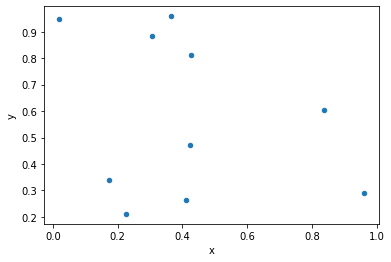

In [123]:
df.plot.scatter(x='x', y='y')

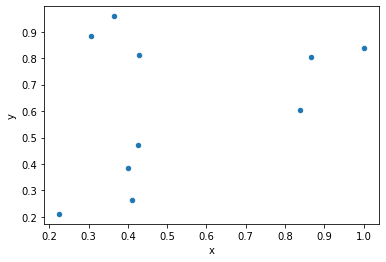

In [122]:
best.plot.scatter(x='x', y='y')